This notebook will attempt to finetune detr on the balloons dataset. I am simply replicating the steps from an existing project to start https://github.com/woctezuma/finetune-detr so this shouldn't be too difficult, but will give me an opportunity to make sure I can use my new compute (4090 via groundlight) correctly. In the DETR github page, authors suggest finetuning when one's dataset is smaller than 10k images, which would match groundlight's usecase.  

Sources:  
https://github.com/woctezuma/finetune-detr  
https://github.com/woctezuma/VIA2COCO  
https://github.com/woctezuma/detr.git


# Trying out the model

In [25]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

2.0.1 True


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [3]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [4]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [6]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [8]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /home/sunil/.cache/torch/hub/facebookresearch_detr_main
/home/sunil/miniconda3/envs/ft_detr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sunil/miniconda3/envs/ft_detr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/sunil/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
24.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in ord

In [9]:
model

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [10]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [11]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

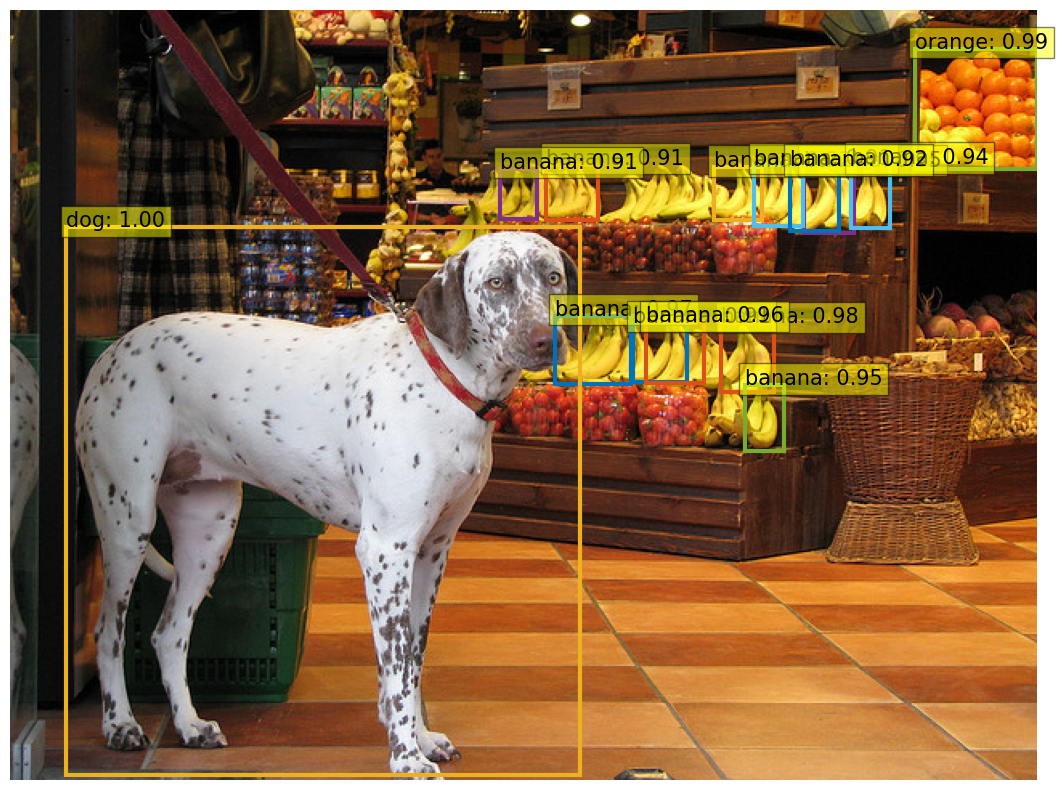

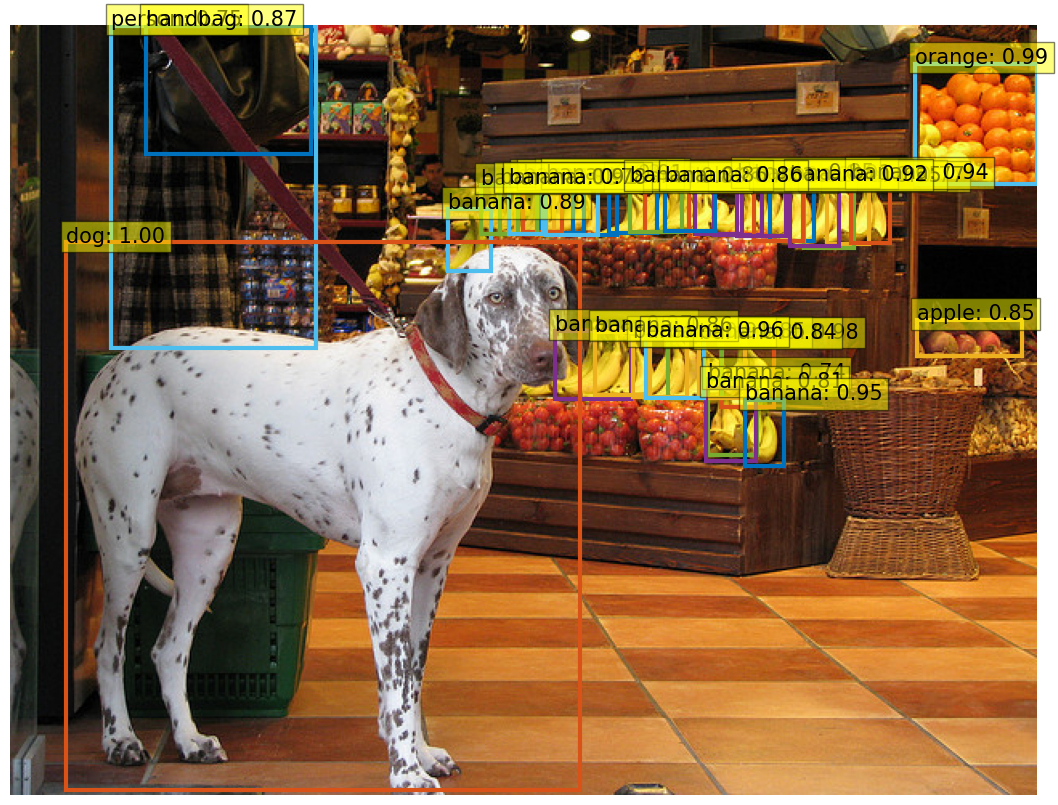

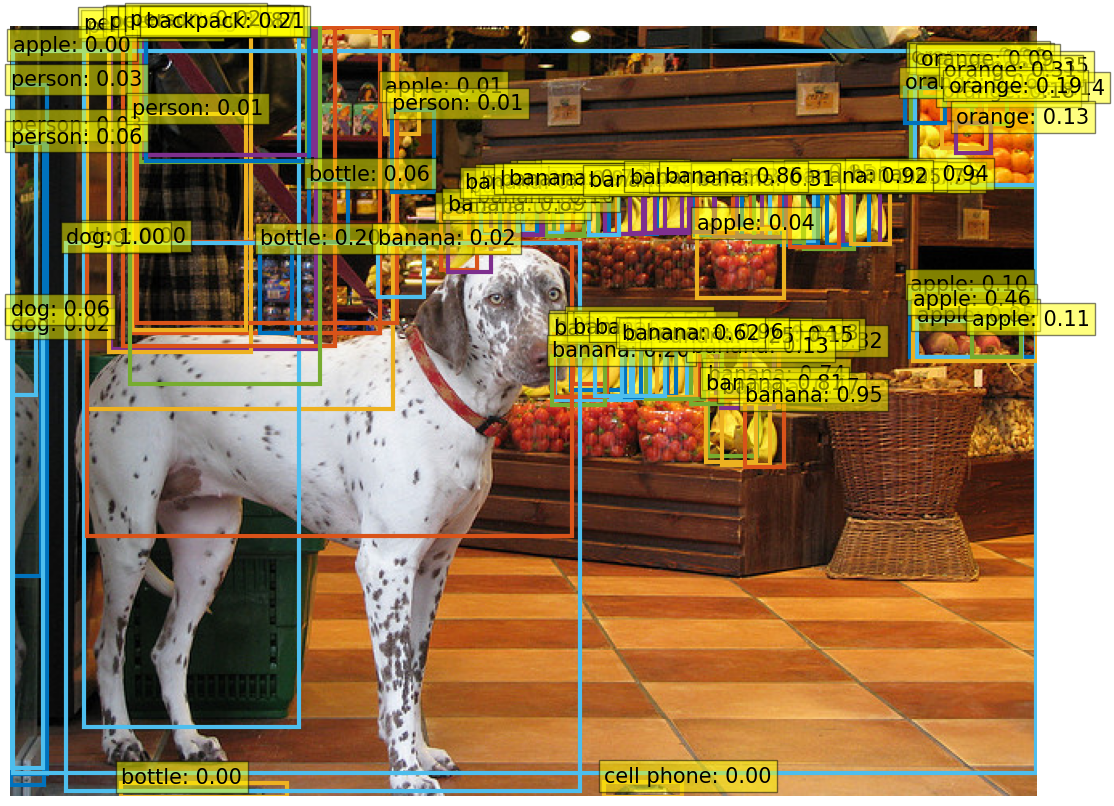

In [14]:
# display bboxes at 3 different confidence thresholds
for threshold in [0.9, 0.7, 0.0]:
  
  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)

  plot_results(im, probas_to_keep, bboxes_scaled)

# Get the model ready for finetuning

In [15]:
# load a checkpoint and remove the classification head

# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

# Ready the data

In [16]:
# set the first class as 0 (detr will set its background class as 1 as a result)
first_class_index = 0

In [20]:
# we need to convert the dataset's format from via to coco for detr
# using https://github.com/woctezuma/VIA2COCO
%cd /home/sunil/VIA2COCO
!ls

/home/sunil/VIA2COCO
convert.py  getArea.py	LICENSE  __pycache__  README.md


In [23]:
import convert as via2coco
data_path = '/home/sunil/finetune_detr/data/'

for keyword in ['train', 'val']:

  input_dir = data_path + 'balloon/' + keyword + '/'
  input_json = input_dir + 'via_region_data.json'
  categories = ['balloon']
  super_categories = ['N/A']
  output_json = input_dir + 'custom_' + keyword + '.json'

  print('Converting {} from VIA format to COCO format'.format(input_json))

  coco_dict = via2coco.convert(
      imgdir=input_dir,
      annpath=input_json,
      categories=categories,
      super_categories=super_categories,
      output_file_name=output_json,
      first_class_index=first_class_index,
  )

Converting /home/sunil/finetune_detr/data/balloon/train/via_region_data.json from VIA format to COCO format
Saving to /home/sunil/finetune_detr/data/balloon/train/custom_train.json
Converting /home/sunil/finetune_detr/data/balloon/val/via_region_data.json from VIA format to COCO format
Saving to /home/sunil/finetune_detr/data/balloon/val/custom_val.json


In [24]:
# make directory for annotations consistent with what detr expects 
!mkdir -p /home/sunil/finetune_detr/data/balloon/annotations

# move jsons over
!mv /home/sunil/finetune_detr/data/balloon/train/custom_train.json /home/sunil/finetune_detr/data/balloon/annotations/custom_train.json
!mv /home/sunil/finetune_detr/data/balloon/val/custom_val.json /home/sunil/finetune_detr/data/balloon/annotations/custom_val.json

# make directory for training data consistent with what detr expects and move training data here 
!mkdir -p /home/sunil/finetune_detr/data/balloon/train2017/
!mv /home/sunil/finetune_detr/data/balloon/train/*.jpg /home/sunil/finetune_detr/data/balloon/train2017/

# make directory for validation data consistent with what detr expects and move validation data here 
!mkdir -p /home/sunil/finetune_detr/data/balloon/val2017/
!mv /home/sunil/finetune_detr/data/balloon/val/*.jpg /home/sunil/finetune_detr/data/balloon/val2017/



Now that the data is ready, let's visualize some examples to make sure preprocessing worked as expected

In [28]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [29]:
dataDir='/home/sunil/finetune_detr/data/balloon/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [30]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [31]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['balloon']
Super-categories: {'N/A'}


In [32]:
# load and display image
catIds = coco.getCatIds(catNms=['balloon']);
imgIds = coco.getImgIds(catIds=catIds );

Image n°21
Image name: /home/sunil/finetune_detr/data/balloon//train2017/7488015492_0583857ca0_k.jpg


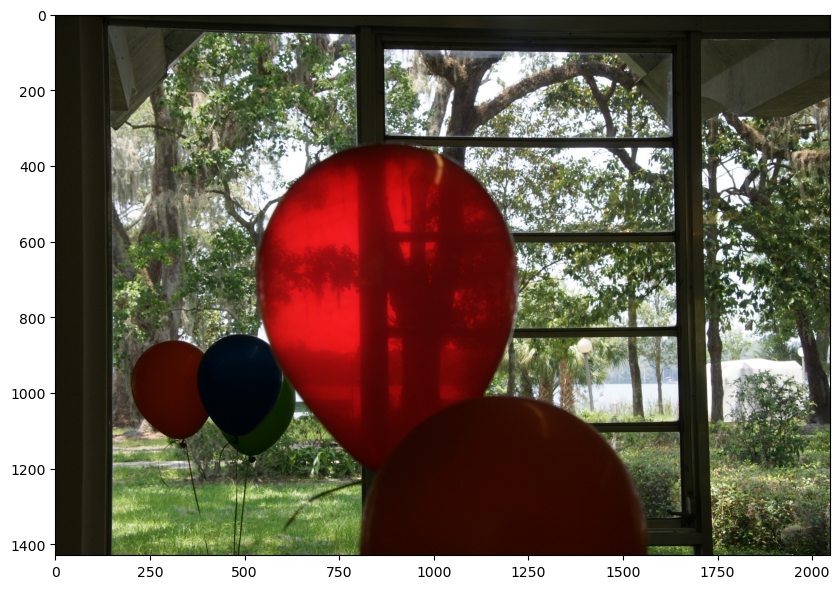

In [34]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [35]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

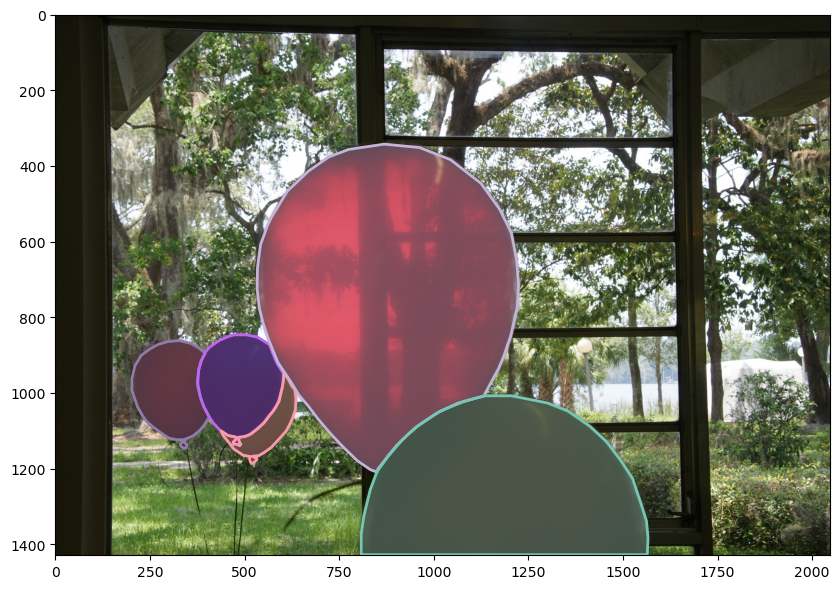

In [36]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

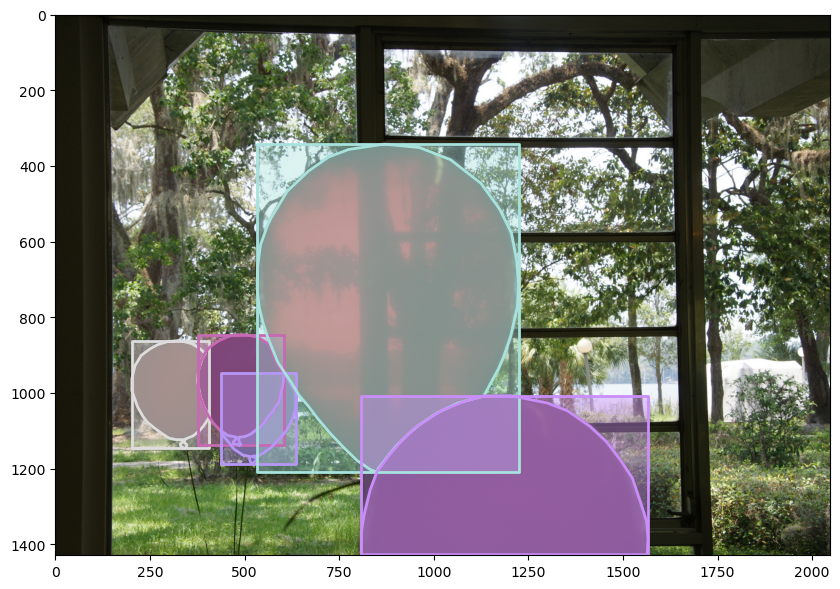

In [37]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

In [38]:
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 1

  finetuned_classes = [
      'balloon',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 2

  finetuned_classes = [
      'N/A', 'balloon',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 1
Fine-tuned classes: ['balloon']


In [40]:
%cd /home/sunil/detr
!ls

/home/sunil/detr
d2	    engine.py	main.py    requirements.txt	 tox.ini
datasets    hubconf.py	models	   run_with_submitit.py  util
Dockerfile  LICENSE	README.md  test_all.py


In [44]:
first_class_index

0

We are now ready to finetune using a fork of DETR I found online :). It runs really quickly on the 4090 (1 minute!)

In [48]:
!python main.py \
  --dataset_file "custom" \
  --coco_path "/home/sunil/finetune_detr/data/balloon/" \
  --output_dir "outputs" \
  --resume "/home/sunil/finetune_detr/detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10

Not using distributed mode
git:
  sha: 3cda3529921efb8870d0b49db7b30aa8477ae359, status: clean, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=10, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=1, dataset_file='custom', coco_path='/home/sunil/finetune_detr/data/balloon/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='/home/sunil/finetune_detr/detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/home/sunil/miniconda3/envs/ft_detr/lib/python3.10/s

Test:  [0/7]  eta: 0:00:02  class_error: 37.50  loss: 5.2690 (5.2690)  loss_ce: 0.3660 (0.3660)  loss_bbox: 0.1296 (0.1296)  loss_giou: 0.3603 (0.3603)  loss_ce_0: 0.4290 (0.4290)  loss_bbox_0: 0.1396 (0.1396)  loss_giou_0: 0.3498 (0.3498)  loss_ce_1: 0.4109 (0.4109)  loss_bbox_1: 0.1331 (0.1331)  loss_giou_1: 0.3706 (0.3706)  loss_ce_2: 0.3699 (0.3699)  loss_bbox_2: 0.1384 (0.1384)  loss_giou_2: 0.3826 (0.3826)  loss_ce_3: 0.3675 (0.3675)  loss_bbox_3: 0.1419 (0.1419)  loss_giou_3: 0.3609 (0.3609)  loss_ce_4: 0.3698 (0.3698)  loss_bbox_4: 0.1210 (0.1210)  loss_giou_4: 0.3282 (0.3282)  loss_ce_unscaled: 0.3660 (0.3660)  class_error_unscaled: 37.5000 (37.5000)  loss_bbox_unscaled: 0.0259 (0.0259)  loss_giou_unscaled: 0.1801 (0.1801)  cardinality_error_unscaled: 7.0000 (7.0000)  loss_ce_0_unscaled: 0.4290 (0.4290)  loss_bbox_0_unscaled: 0.0279 (0.0279)  loss_giou_0_unscaled: 0.1749 (0.1749)  cardinality_error_0_unscaled: 3.5000 (3.5000)  loss_ce_1_unscaled: 0.4109 (0.4109)  loss_bbox_1_u

Epoch: [1]  [20/30]  eta: 0:00:01  lr: 0.000100  class_error: 17.65  loss: 4.4777 (4.8154)  loss_ce: 0.2531 (0.2856)  loss_bbox: 0.1691 (0.1871)  loss_giou: 0.2685 (0.3227)  loss_ce_0: 0.3106 (0.3438)  loss_bbox_0: 0.1464 (0.1745)  loss_giou_0: 0.2251 (0.3157)  loss_ce_1: 0.2652 (0.3125)  loss_bbox_1: 0.1491 (0.1910)  loss_giou_1: 0.2315 (0.3153)  loss_ce_2: 0.2680 (0.3016)  loss_bbox_2: 0.1478 (0.1784)  loss_giou_2: 0.2550 (0.3075)  loss_ce_3: 0.2536 (0.2843)  loss_bbox_3: 0.1811 (0.1927)  loss_giou_3: 0.2557 (0.3218)  loss_ce_4: 0.2536 (0.2847)  loss_bbox_4: 0.1516 (0.1811)  loss_giou_4: 0.2428 (0.3154)  loss_ce_unscaled: 0.2531 (0.2856)  class_error_unscaled: 28.5714 (35.8270)  loss_bbox_unscaled: 0.0338 (0.0374)  loss_giou_unscaled: 0.1342 (0.1613)  cardinality_error_unscaled: 2.0000 (4.1190)  loss_ce_0_unscaled: 0.3106 (0.3438)  loss_bbox_0_unscaled: 0.0293 (0.0349)  loss_giou_0_unscaled: 0.1126 (0.1578)  cardinality_error_0_unscaled: 1.0000 (1.8333)  loss_ce_1_unscaled: 0.2652 (0

DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.564
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
Epoch

Test:  [0/7]  eta: 0:00:01  class_error: 0.00  loss: 4.6779 (4.6779)  loss_ce: 0.0766 (0.0766)  loss_bbox: 0.1628 (0.1628)  loss_giou: 0.5174 (0.5174)  loss_ce_0: 0.2144 (0.2144)  loss_bbox_0: 0.1667 (0.1667)  loss_giou_0: 0.5028 (0.5028)  loss_ce_1: 0.1721 (0.1721)  loss_bbox_1: 0.1637 (0.1637)  loss_giou_1: 0.4900 (0.4900)  loss_ce_2: 0.1583 (0.1583)  loss_bbox_2: 0.1427 (0.1427)  loss_giou_2: 0.4375 (0.4375)  loss_ce_3: 0.0903 (0.0903)  loss_bbox_3: 0.1561 (0.1561)  loss_giou_3: 0.4771 (0.4771)  loss_ce_4: 0.0847 (0.0847)  loss_bbox_4: 0.1573 (0.1573)  loss_giou_4: 0.5074 (0.5074)  loss_ce_unscaled: 0.0766 (0.0766)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0326 (0.0326)  loss_giou_unscaled: 0.2587 (0.2587)  cardinality_error_unscaled: 1.0000 (1.0000)  loss_ce_0_unscaled: 0.2144 (0.2144)  loss_bbox_0_unscaled: 0.0333 (0.0333)  loss_giou_0_unscaled: 0.2514 (0.2514)  cardinality_error_0_unscaled: 7.0000 (7.0000)  loss_ce_1_unscaled: 0.1721 (0.1721)  loss_bbox_1_unsc

Epoch: [3]  [20/30]  eta: 0:00:01  lr: 0.000100  class_error: 0.00  loss: 3.3825 (4.1544)  loss_ce: 0.0769 (0.1106)  loss_bbox: 0.1620 (0.1902)  loss_giou: 0.2804 (0.3529)  loss_ce_0: 0.1649 (0.2158)  loss_bbox_0: 0.1644 (0.2077)  loss_giou_0: 0.3594 (0.3835)  loss_ce_1: 0.1364 (0.1846)  loss_bbox_1: 0.1660 (0.1880)  loss_giou_1: 0.3141 (0.3437)  loss_ce_2: 0.1170 (0.1598)  loss_bbox_2: 0.1576 (0.1735)  loss_giou_2: 0.2590 (0.3231)  loss_ce_3: 0.0973 (0.1257)  loss_bbox_3: 0.1550 (0.1875)  loss_giou_3: 0.2914 (0.3548)  loss_ce_4: 0.0831 (0.1199)  loss_bbox_4: 0.1544 (0.1860)  loss_giou_4: 0.2776 (0.3470)  loss_ce_unscaled: 0.0769 (0.1106)  class_error_unscaled: 0.0000 (5.4783)  loss_bbox_unscaled: 0.0324 (0.0380)  loss_giou_unscaled: 0.1402 (0.1764)  cardinality_error_unscaled: 0.5000 (1.4762)  loss_ce_0_unscaled: 0.1649 (0.2158)  loss_bbox_0_unscaled: 0.0329 (0.0415)  loss_giou_0_unscaled: 0.1797 (0.1917)  cardinality_error_0_unscaled: 2.0000 (5.4762)  loss_ce_1_unscaled: 0.1364 (0.18

Epoch: [4]  [ 0/30]  eta: 0:00:10  lr: 0.000100  class_error: 50.00  loss: 2.0194 (2.0194)  loss_ce: 0.0489 (0.0489)  loss_bbox: 0.1598 (0.1598)  loss_giou: 0.1502 (0.1502)  loss_ce_0: 0.1012 (0.1012)  loss_bbox_0: 0.1527 (0.1527)  loss_giou_0: 0.1924 (0.1924)  loss_ce_1: 0.0778 (0.0778)  loss_bbox_1: 0.0813 (0.0813)  loss_giou_1: 0.1070 (0.1070)  loss_ce_2: 0.0562 (0.0562)  loss_bbox_2: 0.1059 (0.1059)  loss_giou_2: 0.1191 (0.1191)  loss_ce_3: 0.0493 (0.0493)  loss_bbox_3: 0.1370 (0.1370)  loss_giou_3: 0.1250 (0.1250)  loss_ce_4: 0.0504 (0.0504)  loss_bbox_4: 0.1628 (0.1628)  loss_giou_4: 0.1423 (0.1423)  loss_ce_unscaled: 0.0489 (0.0489)  class_error_unscaled: 50.0000 (50.0000)  loss_bbox_unscaled: 0.0320 (0.0320)  loss_giou_unscaled: 0.0751 (0.0751)  cardinality_error_unscaled: 0.5000 (0.5000)  loss_ce_0_unscaled: 0.1012 (0.1012)  loss_bbox_0_unscaled: 0.0305 (0.0305)  loss_giou_0_unscaled: 0.0962 (0.0962)  cardinality_error_0_unscaled: 0.5000 (0.5000)  loss_ce_1_unscaled: 0.0778 (0

Test:  [0/7]  eta: 0:00:01  class_error: 0.00  loss: 5.0316 (5.0316)  loss_ce: 0.0689 (0.0689)  loss_bbox: 0.1790 (0.1790)  loss_giou: 0.4523 (0.4523)  loss_ce_0: 0.1766 (0.1766)  loss_bbox_0: 0.2218 (0.2218)  loss_giou_0: 0.5037 (0.5037)  loss_ce_1: 0.1191 (0.1191)  loss_bbox_1: 0.2241 (0.2241)  loss_giou_1: 0.5814 (0.5814)  loss_ce_2: 0.1399 (0.1399)  loss_bbox_2: 0.2094 (0.2094)  loss_giou_2: 0.5351 (0.5351)  loss_ce_3: 0.0809 (0.0809)  loss_bbox_3: 0.2267 (0.2267)  loss_giou_3: 0.5738 (0.5738)  loss_ce_4: 0.0739 (0.0739)  loss_bbox_4: 0.1879 (0.1879)  loss_giou_4: 0.4771 (0.4771)  loss_ce_unscaled: 0.0689 (0.0689)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0358 (0.0358)  loss_giou_unscaled: 0.2261 (0.2261)  cardinality_error_unscaled: 2.0000 (2.0000)  loss_ce_0_unscaled: 0.1766 (0.1766)  loss_bbox_0_unscaled: 0.0444 (0.0444)  loss_giou_0_unscaled: 0.2519 (0.2519)  cardinality_error_0_unscaled: 7.5000 (7.5000)  loss_ce_1_unscaled: 0.1191 (0.1191)  loss_bbox_1_unsc

Epoch: [5]  [20/30]  eta: 0:00:01  lr: 0.000100  class_error: 25.00  loss: 3.6503 (4.4380)  loss_ce: 0.0738 (0.1172)  loss_bbox: 0.1765 (0.1955)  loss_giou: 0.3214 (0.3589)  loss_ce_0: 0.2148 (0.2373)  loss_bbox_0: 0.2036 (0.2319)  loss_giou_0: 0.3289 (0.4190)  loss_ce_1: 0.1337 (0.1936)  loss_bbox_1: 0.1953 (0.2025)  loss_giou_1: 0.3403 (0.3935)  loss_ce_2: 0.0997 (0.1603)  loss_bbox_2: 0.1847 (0.2017)  loss_giou_2: 0.3039 (0.3664)  loss_ce_3: 0.0886 (0.1340)  loss_bbox_3: 0.1694 (0.1942)  loss_giou_3: 0.2895 (0.3639)  loss_ce_4: 0.0796 (0.1217)  loss_bbox_4: 0.1724 (0.1911)  loss_giou_4: 0.2953 (0.3553)  loss_ce_unscaled: 0.0738 (0.1172)  class_error_unscaled: 0.0000 (6.9704)  loss_bbox_unscaled: 0.0353 (0.0391)  loss_giou_unscaled: 0.1607 (0.1795)  cardinality_error_unscaled: 1.0000 (2.6429)  loss_ce_0_unscaled: 0.2148 (0.2373)  loss_bbox_0_unscaled: 0.0407 (0.0464)  loss_giou_0_unscaled: 0.1645 (0.2095)  cardinality_error_0_unscaled: 4.5000 (7.5476)  loss_ce_1_unscaled: 0.1337 (0.1

Test: Total time: 0:00:00 (0.0946 s / it)
Averaged stats: class_error: 0.00  loss: 4.5317 (5.6834)  loss_ce: 0.0459 (0.1897)  loss_bbox: 0.1484 (0.1840)  loss_giou: 0.4134 (0.5264)  loss_ce_0: 0.2302 (0.2708)  loss_bbox_0: 0.1895 (0.2408)  loss_giou_0: 0.4507 (0.6007)  loss_ce_1: 0.1785 (0.2094)  loss_bbox_1: 0.1705 (0.2035)  loss_giou_1: 0.4291 (0.5433)  loss_ce_2: 0.1070 (0.1962)  loss_bbox_2: 0.1733 (0.1833)  loss_giou_2: 0.4142 (0.5493)  loss_ce_3: 0.0618 (0.1802)  loss_bbox_3: 0.1622 (0.1846)  loss_giou_3: 0.3694 (0.5302)  loss_ce_4: 0.0505 (0.1882)  loss_bbox_4: 0.1577 (0.1785)  loss_giou_4: 0.4023 (0.5244)  loss_ce_unscaled: 0.0459 (0.1897)  class_error_unscaled: 0.0000 (15.4545)  loss_bbox_unscaled: 0.0297 (0.0368)  loss_giou_unscaled: 0.2067 (0.2632)  cardinality_error_unscaled: 0.5000 (1.3571)  loss_ce_0_unscaled: 0.2302 (0.2708)  loss_bbox_0_unscaled: 0.0379 (0.0482)  loss_giou_0_unscaled: 0.2254 (0.3004)  cardinality_error_0_unscaled: 3.5000 (5.1429)  loss_ce_1_unscaled: 0.

Epoch: [6] Total time: 0:00:04 (0.1390 s / it)
Averaged stats: lr: 0.000100  class_error: 12.50  loss: 3.7460 (3.7824)  loss_ce: 0.0549 (0.0718)  loss_bbox: 0.1951 (0.1800)  loss_giou: 0.3492 (0.3304)  loss_ce_0: 0.1959 (0.1988)  loss_bbox_0: 0.1980 (0.1996)  loss_giou_0: 0.3488 (0.3401)  loss_ce_1: 0.1172 (0.1381)  loss_bbox_1: 0.1943 (0.1860)  loss_giou_1: 0.3687 (0.3421)  loss_ce_2: 0.0879 (0.1087)  loss_bbox_2: 0.1726 (0.1809)  loss_giou_2: 0.3397 (0.3331)  loss_ce_3: 0.0551 (0.0787)  loss_bbox_3: 0.2007 (0.1796)  loss_giou_3: 0.3574 (0.3353)  loss_ce_4: 0.0580 (0.0740)  loss_bbox_4: 0.1907 (0.1785)  loss_giou_4: 0.3494 (0.3266)  loss_ce_unscaled: 0.0549 (0.0718)  class_error_unscaled: 0.0000 (4.0132)  loss_bbox_unscaled: 0.0390 (0.0360)  loss_giou_unscaled: 0.1746 (0.1652)  cardinality_error_unscaled: 0.5000 (1.1000)  loss_ce_0_unscaled: 0.1959 (0.1988)  loss_bbox_0_unscaled: 0.0396 (0.0399)  loss_giou_0_unscaled: 0.1744 (0.1701)  cardinality_error_0_unscaled: 3.5000 (5.8167)  los

Epoch: [7]  [10/30]  eta: 0:00:02  lr: 0.000100  class_error: 10.00  loss: 5.3898 (5.0208)  loss_ce: 0.1780 (0.1521)  loss_bbox: 0.1977 (0.2158)  loss_giou: 0.3908 (0.4285)  loss_ce_0: 0.2705 (0.2710)  loss_bbox_0: 0.2439 (0.2301)  loss_giou_0: 0.3718 (0.4581)  loss_ce_1: 0.2439 (0.2223)  loss_bbox_1: 0.2073 (0.2228)  loss_giou_1: 0.3674 (0.4366)  loss_ce_2: 0.2044 (0.1820)  loss_bbox_2: 0.1892 (0.2081)  loss_giou_2: 0.3931 (0.4130)  loss_ce_3: 0.1427 (0.1525)  loss_bbox_3: 0.2118 (0.2168)  loss_giou_3: 0.4103 (0.4199)  loss_ce_4: 0.1814 (0.1546)  loss_bbox_4: 0.1985 (0.2152)  loss_giou_4: 0.3918 (0.4213)  loss_ce_unscaled: 0.1780 (0.1521)  class_error_unscaled: 6.2500 (8.2808)  loss_bbox_unscaled: 0.0395 (0.0432)  loss_giou_unscaled: 0.1954 (0.2143)  cardinality_error_unscaled: 3.5000 (4.0455)  loss_ce_0_unscaled: 0.2705 (0.2710)  loss_bbox_0_unscaled: 0.0488 (0.0460)  loss_giou_0_unscaled: 0.1859 (0.2290)  cardinality_error_0_unscaled: 4.5000 (8.3636)  loss_ce_1_unscaled: 0.2439 (0.2

Test:  [6/7]  eta: 0:00:00  class_error: 0.00  loss: 5.6897 (6.2508)  loss_ce: 0.0626 (0.2168)  loss_bbox: 0.1773 (0.2066)  loss_giou: 0.5344 (0.6325)  loss_ce_0: 0.2092 (0.2634)  loss_bbox_0: 0.1611 (0.2107)  loss_giou_0: 0.5165 (0.5890)  loss_ce_1: 0.1493 (0.2015)  loss_bbox_1: 0.1602 (0.1961)  loss_giou_1: 0.5155 (0.5886)  loss_ce_2: 0.1067 (0.2227)  loss_bbox_2: 0.1640 (0.1986)  loss_giou_2: 0.5383 (0.6166)  loss_ce_3: 0.0724 (0.2115)  loss_bbox_3: 0.1683 (0.2120)  loss_giou_3: 0.5389 (0.6456)  loss_ce_4: 0.0675 (0.2209)  loss_bbox_4: 0.1617 (0.2030)  loss_giou_4: 0.5197 (0.6148)  loss_ce_unscaled: 0.0626 (0.2168)  class_error_unscaled: 0.0000 (17.0996)  loss_bbox_unscaled: 0.0355 (0.0413)  loss_giou_unscaled: 0.2672 (0.3162)  cardinality_error_unscaled: 1.0000 (1.7857)  loss_ce_0_unscaled: 0.2092 (0.2634)  loss_bbox_0_unscaled: 0.0322 (0.0421)  loss_giou_0_unscaled: 0.2583 (0.2945)  cardinality_error_0_unscaled: 5.0000 (5.7143)  loss_ce_1_unscaled: 0.1493 (0.2015)  loss_bbox_1_uns

Epoch: [8]  [29/30]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 3.6906 (4.0444)  loss_ce: 0.0315 (0.0808)  loss_bbox: 0.1883 (0.1948)  loss_giou: 0.3141 (0.3712)  loss_ce_0: 0.1567 (0.1928)  loss_bbox_0: 0.2104 (0.1998)  loss_giou_0: 0.3983 (0.3891)  loss_ce_1: 0.1047 (0.1510)  loss_bbox_1: 0.1733 (0.1787)  loss_giou_1: 0.2999 (0.3400)  loss_ce_2: 0.0647 (0.1092)  loss_bbox_2: 0.1806 (0.1896)  loss_giou_2: 0.3149 (0.3651)  loss_ce_3: 0.0406 (0.0865)  loss_bbox_3: 0.1837 (0.1944)  loss_giou_3: 0.3150 (0.3612)  loss_ce_4: 0.0326 (0.0815)  loss_bbox_4: 0.1803 (0.1912)  loss_giou_4: 0.3128 (0.3674)  loss_ce_unscaled: 0.0315 (0.0808)  class_error_unscaled: 0.0000 (7.5777)  loss_bbox_unscaled: 0.0377 (0.0390)  loss_giou_unscaled: 0.1571 (0.1856)  cardinality_error_unscaled: 1.0000 (1.2667)  loss_ce_0_unscaled: 0.1567 (0.1928)  loss_bbox_0_unscaled: 0.0421 (0.0400)  loss_giou_0_unscaled: 0.1991 (0.1946)  cardinality_error_0_unscaled: 4.0000 (5.8167)  loss_ce_1_unscaled: 0.1047 (0.15

Epoch: [9]  [ 0/30]  eta: 0:00:10  lr: 0.000100  class_error: 7.14  loss: 6.1106 (6.1106)  loss_ce: 0.1061 (0.1061)  loss_bbox: 0.1783 (0.1783)  loss_giou: 0.6654 (0.6654)  loss_ce_0: 0.3003 (0.3003)  loss_bbox_0: 0.2369 (0.2369)  loss_giou_0: 0.6955 (0.6955)  loss_ce_1: 0.2426 (0.2426)  loss_bbox_1: 0.1501 (0.1501)  loss_giou_1: 0.6342 (0.6342)  loss_ce_2: 0.1564 (0.1564)  loss_bbox_2: 0.1685 (0.1685)  loss_giou_2: 0.6872 (0.6872)  loss_ce_3: 0.1532 (0.1532)  loss_bbox_3: 0.1610 (0.1610)  loss_giou_3: 0.6253 (0.6253)  loss_ce_4: 0.1356 (0.1356)  loss_bbox_4: 0.1792 (0.1792)  loss_giou_4: 0.6346 (0.6346)  loss_ce_unscaled: 0.1061 (0.1061)  class_error_unscaled: 7.1429 (7.1429)  loss_bbox_unscaled: 0.0357 (0.0357)  loss_giou_unscaled: 0.3327 (0.3327)  cardinality_error_unscaled: 1.5000 (1.5000)  loss_ce_0_unscaled: 0.3003 (0.3003)  loss_bbox_0_unscaled: 0.0474 (0.0474)  loss_giou_0_unscaled: 0.3478 (0.3478)  cardinality_error_0_unscaled: 7.0000 (7.0000)  loss_ce_1_unscaled: 0.2426 (0.24

Test:  [0/7]  eta: 0:00:01  class_error: 0.00  loss: 3.2590 (3.2590)  loss_ce: 0.0543 (0.0543)  loss_bbox: 0.1198 (0.1198)  loss_giou: 0.3839 (0.3839)  loss_ce_0: 0.1746 (0.1746)  loss_bbox_0: 0.1082 (0.1082)  loss_giou_0: 0.3384 (0.3384)  loss_ce_1: 0.1001 (0.1001)  loss_bbox_1: 0.1183 (0.1183)  loss_giou_1: 0.2991 (0.2991)  loss_ce_2: 0.0730 (0.0730)  loss_bbox_2: 0.1152 (0.1152)  loss_giou_2: 0.3466 (0.3466)  loss_ce_3: 0.0581 (0.0581)  loss_bbox_3: 0.1134 (0.1134)  loss_giou_3: 0.3311 (0.3311)  loss_ce_4: 0.0577 (0.0577)  loss_bbox_4: 0.1094 (0.1094)  loss_giou_4: 0.3578 (0.3578)  loss_ce_unscaled: 0.0543 (0.0543)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0240 (0.0240)  loss_giou_unscaled: 0.1919 (0.1919)  cardinality_error_unscaled: 1.5000 (1.5000)  loss_ce_0_unscaled: 0.1746 (0.1746)  loss_bbox_0_unscaled: 0.0216 (0.0216)  loss_giou_0_unscaled: 0.1692 (0.1692)  cardinality_error_0_unscaled: 7.0000 (7.0000)  loss_ce_1_unscaled: 0.1001 (0.1001)  loss_bbox_1_unsc

/home/sunil/detr
